# The Battle of CA Neighborhoods

In [1]:
import numpy as np
import pandas as pd
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize # to flatten json file and use pandas to read it

! pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude

from sklearn.cluster import KMeans

import folium
import requests

print("import done")

     |████████████████████████████████| 112kB 23.4MB/s eta 0:00:01
import done


In [2]:
# First, to clean the CA Crime data, and calculate the Crime Density which is the total number of crimes divided by the population of the city

df_off=pd.read_csv('ca_offenses_by_city.csv', index_col=None)
df_off.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft,Arson
0,Adelanto,33005,212,2,14,NaN,48,148,808,434,254,120,24
1,Agoura Hills,20970,15,0,1,NaN,6,8,310,82,217,11,0
2,Alameda,78613,148,2,7,NaN,61,78,"1,819",228,"1,245",346,18
3,Albany,19723,34,1,6,NaN,16,11,605,95,447,63,0
4,Alhambra3,86175,168,1,13,NaN,74,80,"1,929",305,"1,413",211,6


In [3]:
df_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   City                                  460 non-null    object 
 1   Population                            460 non-null    int64  
 2   Violent crime                         460 non-null    object 
 3   Murder and nonnegligent manslaughter  460 non-null    int64  
 4   Rape (revised definition)             460 non-null    object 
 5   Rape (legacy definition)              0 non-null      float64
 6   Robbery                               460 non-null    object 
 7   Aggravated assault                    460 non-null    object 
 8   Property crime                        460 non-null    object 
 9   Burglary                              460 non-null    object 
 10  Larceny-theft                         460 non-null    object 
 11  Motor vehicle theft

In [4]:
# almost all filds are string type rather than numeric type. Need to convert the type

df_off['Robbery']=pd.to_numeric(df_off.Robbery, errors='coerce')
df_off['Violent crime']=pd.to_numeric(df_off['Violent crime'], errors='coerce')
df_off['Burglary']=pd.to_numeric(df_off.Burglary, errors='coerce')
df_off['Arson']=pd.to_numeric(df_off.Arson, errors='coerce')
df_off['Murder and nonnegligent manslaughter']=pd.to_numeric(df_off['Murder and nonnegligent manslaughter'], errors='coerce')
df_off['Rape (revised definition)']=pd.to_numeric(df_off['Rape (revised definition)'], errors='coerce')
df_off['Aggravated assault']=pd.to_numeric(df_off['Aggravated assault'], errors='coerce')
df_off['Property crime']=pd.to_numeric(df_off['Property crime'], errors='coerce')
df_off['Larceny-theft']=pd.to_numeric(df_off['Larceny-theft'], errors='coerce')
df_off['Motor vehicle theft']=pd.to_numeric(df_off['Motor vehicle theft'], errors='coerce')

In [5]:
df_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   City                                  460 non-null    object 
 1   Population                            460 non-null    int64  
 2   Violent crime                         442 non-null    float64
 3   Murder and nonnegligent manslaughter  460 non-null    int64  
 4   Rape (revised definition)             459 non-null    float64
 5   Rape (legacy definition)              0 non-null      float64
 6   Robbery                               451 non-null    float64
 7   Aggravated assault                    448 non-null    float64
 8   Property crime                        263 non-null    float64
 9   Burglary                              440 non-null    float64
 10  Larceny-theft                         315 non-null    float64
 11  Motor vehicle theft

In [6]:
# Calcualte the Crime Density

df_off['Total']=df_off.sum(axis=1)
df_off['Tot Crime']=df_off['Total']-df_off['Population']
df_off['Crime Density']=df_off['Population']/df_off['Tot Crime']

In [7]:
df_off.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft,Arson,Total,Tot Crime,Crime Density
0,Adelanto,33005,212.0,2,14.0,NaN,48.0,148.0,808.0,434.0,254.0,120.0,24.0,35069.0,2064.0,15.990795
1,Agoura Hills,20970,15.0,0,1.0,NaN,6.0,8.0,310.0,82.0,217.0,11.0,0.0,21620.0,650.0,32.261538
2,Alameda,78613,148.0,2,7.0,NaN,61.0,78.0,NaN,228.0,NaN,346.0,18.0,79501.0,888.0,88.528153
3,Albany,19723,34.0,1,6.0,NaN,16.0,11.0,605.0,95.0,447.0,63.0,0.0,21001.0,1278.0,15.432707
4,Alhambra3,86175,168.0,1,13.0,NaN,74.0,80.0,NaN,305.0,NaN,211.0,6.0,87033.0,858.0,100.437063


In [8]:
df_crime=df_off[['City', 'Crime Density']]

In [9]:
df_crime['City']=df_crime['City'].str.upper()
df_crime.describe()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Crime Density
count,460.000000
mean,99.699919
std,680.440412
min,0.173109
25%,20.528201
50%,31.922683
75%,57.582230
max,14052.219858


In [10]:
df_crime=df_crime.sort_values('Crime Density', ascending=False)
df_crime.head()

,City,Crime Density
233,LOS ANGELES,14052.219858
358,SAN JOSE,2071.200803
351,SAN DIEGO,1802.402831
345,SACRAMENTO,1700.406250
229,LONG BEACH,1689.070922


In [11]:
df_school=pd.read_csv('Public_Schools.csv', index_col=None)
df_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10442 entries, 0 to 10441
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           10442 non-null  float64
 1   Y           10442 non-null  float64
 2   OBJECTID    10442 non-null  int64  
 3   NCESID      10442 non-null  float64
 4   NAME        10442 non-null  object 
 5   ADDRESS     10442 non-null  object 
 6   CITY        10442 non-null  object 
 7   STATE       10442 non-null  object 
 8   ZIP         10442 non-null  int64  
 9   ZIP4        10442 non-null  object 
 10  TELEPHONE   10442 non-null  object 
 11  TYPE        10442 non-null  int64  
 12  STATUS      10442 non-null  int64  
 13  POPULATION  10442 non-null  int64  
 14  COUNTY      10442 non-null  object 
 15  COUNTYFIPS  10442 non-null  int64  
 16  COUNTRY     10442 non-null  object 
 17  LATITUDE    10442 non-null  float64
 18  LONGITUDE   10442 non-null  float64
 19  NAICS_CODE  10442 non-nul

In [12]:
df_school=df_school[['CITY', 'COUNTY', 'LEVEL_', 'ENROLLMENT', 'FT_TEACHER', 'LATITUDE', 'LONGITUDE']]

In [13]:
df_school=df_school[df_school['LEVEL_']=='ELEMENTARY']
df_school=df_school[~df_school.isin([np.nan, np.inf, -np.inf]).any(1)]
df_school=df_school[df_school['ENROLLMENT']>0]
df_school=df_school[df_school['FT_TEACHER']>0]

In [14]:
df_school['ST_Ratio']=df_school['ENROLLMENT']/df_school['FT_TEACHER']
df_school.rename(columns={"CITY": "City"}, inplace=True)
df_school.set_index('City')
df_school.sort_values(by='City')
df_school.describe()

,ENROLLMENT,FT_TEACHER,LATITUDE,LONGITUDE,ST_Ratio
count,5888.000000,5888.000000,5888.000000,5888.000000,5888.000000
mean,514.633152,21.273098,35.766480,-119.568178,23.890135
std,226.719311,8.846970,2.181693,2.009101,8.342444
min,1.000000,1.000000,32.548093,-124.285534,1.000000
25%,376.000000,16.000000,33.956151,-121.562964,22.166667
50%,513.000000,21.000000,34.655872,-119.009094,24.045455
75%,652.000000,27.000000,37.728546,-117.930392,25.750000
max,1706.000000,67.000000,41.988635,-114.408211,455.000000


In [15]:
df_school[df_school['ST_Ratio']>=0]
df_school_agg=df_school.groupby('City', as_index=False).agg({"ST_Ratio":"mean"})
df_school_agg.head(10)

,City,ST_Ratio
0,ACAMPO,20.150000
1,ACTON,22.631579
2,ADELANTO,24.898397
3,AGOURA,22.306022
4,AGOURA HILLS,20.666667
5,AGUANGA,16.714286
6,AHWAHNEE,12.615385
7,ALAMEDA,25.435933
8,ALAMO,25.812030
9,ALBANY,24.466063


In [16]:
df_school_r=pd.merge(df_school_agg, df_school[['City', 'COUNTY', 'LATITUDE', 'LONGITUDE']], how='left', on='City')
df_school_r.head(10)

,City,ST_Ratio,COUNTY,LATITUDE,LONGITUDE
0,ACAMPO,20.150000,SAN JOAQUIN,38.218030,-121.227838
1,ACAMPO,20.150000,SAN JOAQUIN,38.174175,-121.260869
2,ACTON,22.631579,LOS ANGELES,34.474301,-118.185573
3,ADELANTO,24.898397,SAN BERNARDINO,34.478729,-117.388732
4,ADELANTO,24.898397,SAN BERNARDINO,34.575770,-117.408737
5,ADELANTO,24.898397,SAN BERNARDINO,34.542270,-117.413513
6,ADELANTO,24.898397,SAN BERNARDINO,34.511856,-117.417450
7,ADELANTO,24.898397,SAN BERNARDINO,34.532525,-117.418029
8,ADELANTO,24.898397,SAN BERNARDINO,34.582194,-117.422541
9,ADELANTO,24.898397,SAN BERNARDINO,34.512291,-117.432197


In [17]:
df_school_f=df_school_r.drop_duplicates()
df_school_f.head()

,City,ST_Ratio,COUNTY,LATITUDE,LONGITUDE
0,ACAMPO,20.150000,SAN JOAQUIN,38.218030,-121.227838
1,ACAMPO,20.150000,SAN JOAQUIN,38.174175,-121.260869
2,ACTON,22.631579,LOS ANGELES,34.474301,-118.185573
3,ADELANTO,24.898397,SAN BERNARDINO,34.478729,-117.388732
4,ADELANTO,24.898397,SAN BERNARDINO,34.575770,-117.408737


In [18]:
df=df_school_f.merge(df_crime, on='City')
df.sort_values(['City'])
df.head()

,City,ST_Ratio,COUNTY,LATITUDE,LONGITUDE,Crime Density
0,ADELANTO,24.898397,SAN BERNARDINO,34.478729,-117.388732,15.990795
1,ADELANTO,24.898397,SAN BERNARDINO,34.575770,-117.408737,15.990795
2,ADELANTO,24.898397,SAN BERNARDINO,34.542270,-117.413513,15.990795
3,ADELANTO,24.898397,SAN BERNARDINO,34.511856,-117.417450,15.990795
4,ADELANTO,24.898397,SAN BERNARDINO,34.532525,-117.418029,15.990795


In [19]:
City_LL=df.groupby('City').first()
City_LL=City_LL[~City_LL.isin([np.nan, np.inf, -np.inf]).any(1)]
City_LL=City_LL.sort_values('ST_Ratio', ascending=False)
City_LL.head()

,ST_Ratio,COUNTY,LATITUDE,LONGITUDE,Crime Density
City,,,,,
YUBA CITY,51.438689,SUTTER,39.088342,-121.610300,61.200371
SAN MARCOS,41.021301,SAN DIEGO,33.106135,-117.166066,51.244086
SAN BRUNO,30.869683,SAN MATEO,37.612206,-122.400335,32.854230
NEWARK,29.882568,ALAMEDA,37.529168,-122.015569,32.843251
RANCHO SANTA MARGARITA,29.496898,ORANGE,33.653446,-117.579770,71.538129


In [20]:
City_LL=City_LL[City_LL['ST_Ratio']>0]
City_LL=City_LL.sort_values('ST_Ratio', ascending=True)
City_LL.head()

,ST_Ratio,COUNTY,LATITUDE,LONGITUDE,Crime Density
City,,,,,
YREKA,12.590909,SISKIYOU,41.727420,-122.641012,10.528752
ROSS,15.480000,MARIN,37.961429,-122.557762,32.051282
CAPITOLA,16.000000,SANTA CRUZ,36.969724,-121.959975,7.429716
ANDERSON,16.648639,SHASTA,40.479791,-122.274918,9.126998
ST. HELENA,17.916667,NAPA,38.493685,-122.467328,29.841584


In [21]:
df_HV=pd.read_csv('Neighborhood_CA_HomeValue.csv', index_col=None)

In [22]:
df_HV=df_HV[['RegionName', 'RegionType', 'City', 'CountyName', '10/31/2020']]
df_HV=df_HV.sort_values(by='10/31/2020', ascending=False)
df_HV.head()

,RegionName,RegionType,City,CountyName,10/31/2020
757,Presidio Heights,Neighborhood,San Francisco,San Francisco County,6928378
165,Pacific Heights,Neighborhood,San Francisco,San Francisco County,6794330
1873,Paradise Cove,Neighborhood,Malibu,Los Angeles County,5997223
1658,Sycamore Park,Neighborhood,Malibu,Los Angeles County,5929751
1644,Shady Canyon,Neighborhood,Irvine,Orange County,5822532


In [23]:
df_HV=df_HV.rename(columns={'10/31/2020': 'Recent Homevalue', 'RegionName': 'Neighborhood', 'CountyName': 'COUNTY'})
df_HV['COUNTY']=df_HV['COUNTY'].str.rstrip('County')
df_HV.head()

,Neighborhood,RegionType,City,COUNTY,Recent Homevalue
757,Presidio Heights,Neighborhood,San Francisco,San Francisco,6928378
165,Pacific Heights,Neighborhood,San Francisco,San Francisco,6794330
1873,Paradise Cove,Neighborhood,Malibu,Los Angeles,5997223
1658,Sycamore Park,Neighborhood,Malibu,Los Angeles,5929751
1644,Shady Canyon,Neighborhood,Irvine,Orange,5822532


In [24]:
df_HV['COUNTY']=df_HV['COUNTY'].str.upper()
df_HV['City']=df_HV['City'].str.upper()
df_HV.head()

,Neighborhood,RegionType,City,COUNTY,Recent Homevalue
757,Presidio Heights,Neighborhood,SAN FRANCISCO,SAN FRANCISCO,6928378
165,Pacific Heights,Neighborhood,SAN FRANCISCO,SAN FRANCISCO,6794330
1873,Paradise Cove,Neighborhood,MALIBU,LOS ANGELES,5997223
1658,Sycamore Park,Neighborhood,MALIBU,LOS ANGELES,5929751
1644,Shady Canyon,Neighborhood,IRVINE,ORANGE,5822532


In [26]:
df_HV_agg=df_HV.groupby('City', as_index=False).agg({"Recent Homevalue":"mean"})
df_HV_agg=df_HV_agg.sort_values(by='Recent Homevalue', ascending=True)
df_HV_agg.head()

,City,Recent Homevalue
102,TEHACHAPI,200309.000000
32,FRESNO,277853.555556
108,VISALIA,289761.285714
4,BAKERSFIELD,307763.238095
50,MENIFEE,324872.666667


In [26]:
City_LL.head()

,ST_Ratio,COUNTY,LATITUDE,LONGITUDE,Crime Density
City,,,,,
YREKA,12.590909,SISKIYOU,41.727420,-122.641012,10.528752
ROSS,15.480000,MARIN,37.961429,-122.557762,32.051282
CAPITOLA,16.000000,SANTA CRUZ,36.969724,-121.959975,7.429716
ANDERSON,16.648639,SHASTA,40.479791,-122.274918,9.126998
ST. HELENA,17.916667,NAPA,38.493685,-122.467328,29.841584


In [27]:
df_HV_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 48 to 102
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   City              114 non-null    object 
 1   Recent Homevalue  114 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


In [39]:
df2=City_LL.merge(df_HV_agg[['City', 'Recent Homevalue']], on=["City"])
df2.head()

,City,ST_Ratio,COUNTY,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue
0,BERKELEY,20.218041,ALAMEDA,37.857469,-122.245016,66.918844,1.308087e+06
1,GUSTINE,20.629630,MERCED,37.249009,-120.998405,17.143713,3.669970e+05
2,AGOURA HILLS,20.666667,LOS ANGELES,34.166950,-118.789281,32.261538,1.062729e+06
3,MALIBU,20.893098,LOS ANGELES,34.038670,-118.698396,16.904021,4.753635e+06
4,MARINA,20.927193,MONTEREY,36.675087,-121.785802,17.711167,7.245150e+05


In [40]:
df2=df2.set_index('COUNTY')
df2.shape

(85, 6)

In [41]:
df2.round(6)
df2['Recent Homevalue']=df2['Recent Homevalue'].round(1)
df2.head()

,City,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue
COUNTY,,,,,,
ALAMEDA,BERKELEY,20.218041,37.857469,-122.245016,66.918844,1308087.0
MERCED,GUSTINE,20.629630,37.249009,-120.998405,17.143713,366997.0
LOS ANGELES,AGOURA HILLS,20.666667,34.166950,-118.789281,32.261538,1062728.8
LOS ANGELES,MALIBU,20.893098,34.038670,-118.698396,16.904021,4753634.7
MONTEREY,MARINA,20.927193,36.675087,-121.785802,17.711167,724515.0


In [31]:
df2.to_csv('df2-pre-fun.csv')

In [32]:
df2=df2.drop_duplicates()
df2.shape

(85, 6)

In [ ]:
############## get foursquare info ###############

In [ ]:
CLIENT_ID = 'ASAN4EGUHIXDLUTRX0V4AJ0KES5LFP50D1PCKADEVBIMPEMA' # your Foursquare ID
CLIENT_SECRET = 'EW0WDST0APED43DTGG2QLM4H4QG5Q0L3XFRPRMXYB242FVCV' # your Foursquare Secret
ACCESS_TOKEN = 'SFAVAT2Z10M2RRJJ2VHX1E420R52VOUX2IPSLA4VG0NHU5ZU' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
address = 'Alameda, California'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

In [ ]:
Limit=50
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, LIMIT)
url

In [ ]:
results = requests.get(url).json()
results

In [ ]:
# assign relevant part of JSON to venues
categories = results['response']['venues']

# tranform venues into a dataframe
cat_data = pd.json_normalize(categories)
cat_data[:1]

In [ ]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories', 'location.city']
dataframe_filtered = cat_data.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered

In [ ]:
top_cat=dataframe_filtered.groupby('categories').count().reset_index()
top_cat=top_cat.drop(['city'], axis=1)
top_cat=top_cat.rename(columns={'name': 'count'})
top_cat

In [ ]:
top_cat.sort_values('count', ascending=False)
top_cat=top_cat[top_cat['count']>1]
top_cat

In [ ]:
column_names=['hood', 'long', 'lat']
hood_venue=pd.DataFrame(columns=column_names)
hood_venue

In [ ]:
df2.info()

In [ ]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
    
    # create the API request URL
        Limit=50
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, Limit)
    
    
    # make the GET request
        city_results = requests.get(url).json()
        categories=city_results['response']['venues']
        city_cat_data = pd.json_normalize(categories)
        
        
        city_columns = ['name', 'categories', 'location.city']
        city_cat_all= city_cat_data.loc[:, city_columns]      
    
    # keep only columns that include venue name and categories
    # return only relevant information for each nearby venue
        venues_list=pd.DataFrame(columns=['name', 'categories', 'location.city'])
        venues_list=venues_list.append(city_cat_all)
       
        
    return(venues_list)
        

In [ ]:
# type your answer here
get_categories = getNearbyVenues(names=df2['City'], 
                         latitudes=df2['LATITUDE'],
                         longitudes=df2['LONGITUDE']
                        )

In [42]:
city_categories=pd.read_csv('total_Cat.csv', index_col=0)
city_categories.head()

,categories,count,City
0,Bridge,2,ALAMEDA
1,Park,2,ALAMEDA
2,Trail,8,ALAMEDA
3,Doctor's Office,3,AGOURA HILLS
4,Hotel,2,AGOURA HILLS


In [43]:
city_most_common=city_categories.groupby('categories').sum()
city_most_common=city_most_common.sort_values(by='count', ascending=False)
city_most_common.reset_index()
city_most_common.head(10)

,count
categories,
Salon / Barbershop,42
Office,38
Mexican Restaurant,37
City Hall,30
Doctor's Office,30
Coffee Shop,29
Trail,25
Automotive Shop,25
Government Building,23


In [44]:
print('There are {} unique categories found in those cities.'. format(city_categories['categories'].nunique()))

There are 108 unique categories found in those cities.


In [45]:
### Analyzing categories in those cities. 

In [46]:
# one hot encoding
cat_onehot = pd.get_dummies(city_categories[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cat_onehot['City'] = city_categories['City'] 

# move neighborhood column to the first column
fixed_columns = [cat_onehot.columns[-1]] + list(cat_onehot.columns[:-1])
cat_onehot = cat_onehot[fixed_columns]

cat_onehot.head()

,City,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Automotive Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Line,Bus Station,Café,Car Wash,Chinese Restaurant,Church,City Hall,Clothing Store,Coffee Shop,College Library,Convenience Store,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Deli / Bodega,Dentist's Office,Doctor's Office,Event Space,Factory,Farmers Market,Fast Food Restaurant,Field,Food,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Medical Center,Mexican Restaurant,Miscellaneous Shop,Music Venue,Nail Salon,Nightclub,Office,Opera House,Other Great Outdoors,Park,Parking,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Police Station,Pool,Post Office,Real Estate Office,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shopping Mall,Spa,Sporting Goods Shop,Tattoo Parlor,Tech Startup,Thai Restaurant,Theater,Trail,Urgent Care Center,Vineyard,Warehouse,Water Park,Wine Bar,Wings Joint
0,ALAMEDA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ALAMEDA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ALAMEDA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,AGOURA HILLS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AGOURA HILLS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
cat_onehot.shape

(307, 109)

In [48]:
cat_onehot = cat_onehot.groupby('City').mean().reset_index()
cat_onehot

,City,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Automotive Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Line,Bus Station,Café,Car Wash,Chinese Restaurant,Church,City Hall,Clothing Store,Coffee Shop,College Library,Convenience Store,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Deli / Bodega,Dentist's Office,Doctor's Office,Event Space,Factory,Farmers Market,Fast Food Restaurant,Field,Food,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Medical Center,Mexican Restaurant,Miscellaneous Shop,Music Venue,Nail Salon,Nightclub,Office,Opera House,Other Great Outdoors,Park,Parking,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Police Station,Pool,Post Office,Real Estate Office,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shopping Mall,Spa,Sporting Goods Shop,Tattoo Parlor,Tech Startup,Thai Restaurant,Theater,Trail,Urgent Care Center,Vineyard,Warehouse,Water Park,Wine Bar,Wings Joint
0,AGOURA HILLS,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.200000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.20,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0,0.0,0.000000,0.200000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.00,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000
1,ALAMEDA,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.0,0.00,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00,0.333333,0.00,0.0,0.0,0.000000,0.00,0.000000
2,ALBANY,0.000000,0.00,0.00,0.000000,0.333333,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000
3,BAKERSFIELD,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.166667,0.166667,0.00,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.166667,0.00,0.000000,0.000000,0.000000,0.0,0

In [49]:
########## prepare data for K-mean Clustering

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Categories'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Categories'.format(ind+1))

# create a new dataframe
city_cat_sorted = pd.DataFrame(columns=columns)
city_cat_sorted['City'] = cat_onehot['City']

for ind in np.arange(cat_onehot.shape[0]):
    city_cat_sorted.iloc[ind, 1:] = return_most_common_venues(cat_onehot.iloc[ind, :], num_top_venues)

city_cat_sorted.head()

,City,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
0,AGOURA HILLS,Hotel,Office,Doctor's Office,Spa,Medical Center,Wings Joint,Fast Food Restaurant
1,ALAMEDA,Park,Trail,Bridge,Wings Joint,Fast Food Restaurant,Courthouse,Coworking Space
2,ALBANY,Pet Store,Automotive Shop,Gas Station,Fast Food Restaurant,Cosmetics Shop,Courthouse,Coworking Space
3,BAKERSFIELD,Government Building,City Hall,Bank,Bar,Italian Restaurant,Office,Wings Joint
4,BELMONT,Playground,Church,Wings Joint,College Library,Cosmetics Shop,Courthouse,Coworking Space


In [52]:
df2.head()

,City,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue
COUNTY,,,,,,
ALAMEDA,BERKELEY,20.218041,37.857469,-122.245016,66.918844,1308087.0
MERCED,GUSTINE,20.629630,37.249009,-120.998405,17.143713,366997.0
LOS ANGELES,AGOURA HILLS,20.666667,34.166950,-118.789281,32.261538,1062728.8
LOS ANGELES,MALIBU,20.893098,34.038670,-118.698396,16.904021,4753634.7
MONTEREY,MARINA,20.927193,36.675087,-121.785802,17.711167,724515.0


In [53]:
df3 =df2[~df2.isin([np.nan, np.inf, -np.inf]).any(1)]
df3.shape

(85, 6)

In [54]:
df_final=df3.merge(cat_onehot, on='City')
df_final.head()
df_final.shape

(83, 114)

In [55]:
df_final['Log HV']=np.log(df_final['Recent Homevalue'])
df_final.describe()

,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Automotive Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Line,Bus Station,Café,Car Wash,Chinese Restaurant,Church,City Hall,Clothing Store,Coffee Shop,College Library,Convenience Store,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Deli / Bodega,Dentist's Office,Doctor's Office,Event Space,Factory,Farmers Market,Fast Food Restaurant,Field,Food,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Medical Center,Mexican Restaurant,Miscellaneous Shop,Music Venue,Nail Salon,Nightclub,Office,Opera House,Other Great Outdoors,Park,Parking,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Police Station,Pool,Post Office,Real Estate Office,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shopping Mall,Spa,Sporting Goods Shop,Tattoo Parlor,Tech Startup,Thai Restaurant,Theater,Trail,Urgent Care Center,Vineyard,Warehouse,Water Park,Wine Bar,Wings Joint,Log HV
count,83.000000,83.000000,83.000000,83.000000,8.300000e+01,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.00000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,23.967599,36.064826,-120.124080,374.394470,1.082305e+06,0.026908,0.003012,0.005422,0.008032,0.025502,0.009438,0.022892,0.008032,0.003012,0.002410,0.004016,0.003012,0.002410,0.003012,0.004016,0.010442,0.008032,0.002410,0.009036,0.006426,0.006024,0.008434,0.020482,0.016064,0.003012,0.042369,0.002008,0.002008,0.004819,0.012048,0.003012,0.009839,0.002410,0.026506,0.037349,0.001721,0.002410,0.002410,0.025904,0.002410,0.008032,0.002008,0.010040,0.003012,0.004418,0.013454,0.017871,0.002410,0.015175,0.019478,0.012048,0.002008,0.004016,0.002410,0.001721,0.007831,0.002410,0.011044,0.004016,0.002008,0.014458,0.006024,0.002410,0.002410,0.010040,0.001721,0.001721,0.011847,0.048394,0.009036,0.002410,0.002410,0.004016,0.032731,0.003012,0.009438,0.02249,0.004418,0.006024,0.002410,0.022605,0.010040,0.006426,0.003012,0.011044,0.002008,0.002410,0.007430,0.006024,0.073896,0.008032,0.007028,0.004819,0.002008,0.014056,0.010557,0.003012,0.006024,0.003012,0.006024,0.003012,0.017068,0.003012,0.012048,0.002410,0.002008,0.005422,0.004016,13.674670
std,1.790709,2.014332,2.098927,1578.727295,8.217745e+05,0.129775,0.027441,0.034932,0.057639,0.081788,0.042864,0.078765,0.044353,0.027441,0.021953,0.036588,0.027441,0.021953,0.027441,0.036588,0.055565,0.051427,0.021953,0.048717,0.042438,0.054882,0.045930,0.123722,0.060286,0.027441,0.105258,0.018294,0.018294,0.030856,0.055419,0

In [56]:
df_final=df_final.drop(df_final['Recent Homevalue'].idxmax(), axis=0)
df_final=df_final.drop(df_final['Crime Density'].idxmax(), axis=0)

df_final.shape

(81, 115)

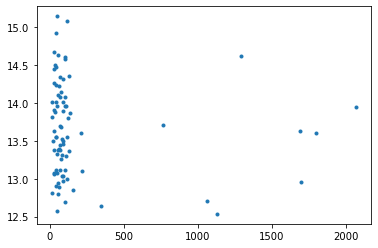

In [57]:
plt.scatter(df_final['Crime Density'], df_final['Log HV'], marker='.')

In [58]:
df_final_clustering=df_final.drop(['City'], 1)

In [59]:
# set number of clusters
kclusters = 5

# set number of clusters to be 5.
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_final_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 3, 4, 0, 1, 4, 1, 4, 3], dtype=int32)

In [60]:
# add clustering labels
df_final.insert(0, 'Cluster Labels', kmeans.labels_)

In [61]:
df_final.head()

,Cluster Labels,City,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Automotive Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Line,Bus Station,Café,Car Wash,Chinese Restaurant,Church,City Hall,Clothing Store,Coffee Shop,College Library,Convenience Store,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Deli / Bodega,Dentist's Office,Doctor's Office,Event Space,Factory,Farmers Market,Fast Food Restaurant,Field,Food,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Medical Center,Mexican Restaurant,Miscellaneous Shop,Music Venue,Nail Salon,Nightclub,Office,Opera House,Other Great Outdoors,Park,Parking,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Police Station,Pool,Post Office,Real Estate Office,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shopping Mall,Spa,Sporting Goods Shop,Tattoo Parlor,Tech Startup,Thai Restaurant,Theater,Trail,Urgent Care Center,Vineyard,Warehouse,Water Park,Wine Bar,Wings Joint,Log HV
0,3,BERKELEY,20.218041,37.857469,-122.245016,66.918844,1308087.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.084076
1,0,GUSTINE,20.629630,37.249009,-120.998405,17.143713,366997.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.00,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.813109
2,3,AGOURA HILLS,20.666667,34.166950,-118.789281,32.261538,1062728.8,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.876350
4,4,MARINA,20.927193,36.675087,-121.785802,17.711167,724515.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.493258
5,0,WEST SACRAMENTO,21.021180,38.594538,-121.520612,49.878673,474806.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0

In [62]:
df_final=df_final[['Cluster Labels', 'City', 'ST_Ratio', 'LATITUDE', 'LONGITUDE', 'Crime Density', 'Recent Homevalue']]
df_description=df_final.merge(city_cat_sorted, on='City')
df_description.head()

,Cluster Labels,City,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
0,3,BERKELEY,20.218041,37.857469,-122.245016,66.918844,1308087.0,Coffee Shop,Automotive Shop,Office,Wings Joint,Fast Food Restaurant,Courthouse,Coworking Space
1,0,GUSTINE,20.629630,37.249009,-120.998405,17.143713,366997.0,Pizza Place,Office,Mexican Restaurant,Building,Factory,College Library,Cosmetics Shop
2,3,AGOURA HILLS,20.666667,34.166950,-118.789281,32.261538,1062728.8,Hotel,Office,Doctor's Office,Spa,Medical Center,Wings Joint,Fast Food Restaurant
3,4,MARINA,20.927193,36.675087,-121.785802,17.711167,724515.0,Pizza Place,Park,Courthouse,Ice Cream Shop,Fast Food Restaurant,Cosmetics Shop,Coworking Space
4,0,WEST SACRAMENTO,21.021180,38.594538,-121.520612,49.878673,474806.0,Pizza Place,Bank,Fast Food Restaurant,Field,Cosmetics Shop,Courthouse,Coworking Space


In [63]:
df_description=df_description.set_index('City')

In [64]:
df_description=df_description.reset_index()
df_description.head()

,City,Cluster Labels,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
0,BERKELEY,3,20.218041,37.857469,-122.245016,66.918844,1308087.0,Coffee Shop,Automotive Shop,Office,Wings Joint,Fast Food Restaurant,Courthouse,Coworking Space
1,GUSTINE,0,20.629630,37.249009,-120.998405,17.143713,366997.0,Pizza Place,Office,Mexican Restaurant,Building,Factory,College Library,Cosmetics Shop
2,AGOURA HILLS,3,20.666667,34.166950,-118.789281,32.261538,1062728.8,Hotel,Office,Doctor's Office,Spa,Medical Center,Wings Joint,Fast Food Restaurant
3,MARINA,4,20.927193,36.675087,-121.785802,17.711167,724515.0,Pizza Place,Park,Courthouse,Ice Cream Shop,Fast Food Restaurant,Cosmetics Shop,Coworking Space
4,WEST SACRAMENTO,0,21.021180,38.594538,-121.520612,49.878673,474806.0,Pizza Place,Bank,Fast Food Restaurant,Field,Cosmetics Shop,Courthouse,Coworking Space


In [65]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
latitude = 36.7783
longitude = -119.4179
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_description['LATITUDE'], df_description['LONGITUDE'], df_description['City'], df_description['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [66]:
df_description=df_description.set_index('City')
df_description.head()

,Cluster Labels,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
City,,,,,,,,,,,,,
BERKELEY,3,20.218041,37.857469,-122.245016,66.918844,1308087.0,Coffee Shop,Automotive Shop,Office,Wings Joint,Fast Food Restaurant,Courthouse,Coworking Space
GUSTINE,0,20.629630,37.249009,-120.998405,17.143713,366997.0,Pizza Place,Office,Mexican Restaurant,Building,Factory,College Library,Cosmetics Shop
AGOURA HILLS,3,20.666667,34.166950,-118.789281,32.261538,1062728.8,Hotel,Office,Doctor's Office,Spa,Medical Center,Wings Joint,Fast Food Restaurant
MARINA,4,20.927193,36.675087,-121.785802,17.711167,724515.0,Pizza Place,Park,Courthouse,Ice Cream Shop,Fast Food Restaurant,Cosmetics Shop,Coworking Space
WEST SACRAMENTO,0,21.021180,38.594538,-121.520612,49.878673,474806.0,Pizza Place,Bank,Fast Food Restaurant,Field,Cosmetics Shop,Courthouse,Coworking Space


In [67]:
df_description.loc[df_description['Cluster Labels'] == 0]

,Cluster Labels,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
City,,,,,,,,,,,,,
GUSTINE,0,20.629630,37.249009,-120.998405,17.143713,366997.0,Pizza Place,Office,Mexican Restaurant,Building,Factory,College Library,Cosmetics Shop
WEST SACRAMENTO,0,21.021180,38.594538,-121.520612,49.878673,474806.0,Pizza Place,Bank,Fast Food Restaurant,Field,Cosmetics Shop,Courthouse,Coworking Space
ROSEVILLE,0,22.868888,38.759966,-121.232915,99.725266,499041.4,Massage Studio,General Entertainment,Health & Beauty Service,Pizza Place,Lounge,Event Space,Spa
PITTSBURG,0,23.036506,38.004154,-121.870823,40.173812,498587.0,Courthouse,Park,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Coworking Space,Credit Union
BAKERSFIELD,0,23.178652,35.392083,-118.881074,343.962282,307763.2,Government Building,City Hall,Bank,Bar,Italian Restaurant,Office,Wings Joint
CATHEDRAL CITY,0,23.372434,33.824100,-116.453390,38.810791,401652.4,Food,Automotive Shop,Pool,Gas Station,Convenience Store,Water Park,General Entertainment
RANCHO CORDOVA,0,23.446602,38.544646,-121.233151,57.593344,416730.2,Pizza Place,Mexican Restaurant,Park,Fast Food Restaurant,Gastropub,General Entertainment,Cosmetics Shop
NATIONAL CITY,0,23.722167,32.685818,-117.073273,28.704771,476464.2,Mexican Restaurant,Grocery Store,Gas Station,Furniture / Home Store,Wings Joint,Cosmetics Shop,Courthouse
MENIFEE,0,23.880826,33.671341,-117.146149,102.654481,324872.7,Wings Joint,Burger Joint,Building,Convenience Store,Courthouse,Coworking Space,Credit Union


In [68]:
df_description.loc['BAKERSFIELD']

Cluster Labels                                  0
ST_Ratio                                  23.1787
LATITUDE                                  35.3921
LONGITUDE                                -118.881
Crime Density                             343.962
Recent Homevalue                           307763
1st Most Common Categories    Government Building
2nd Most Common Categories              City Hall
3rd Most Common Categories                   Bank
4th Most Common Categories                    Bar
5th Most Common Categories     Italian Restaurant
6th Most Common Categories                 Office
7th Most Common Categories            Wings Joint
Name: BAKERSFIELD, dtype: object

In [69]:
df_description.loc[df_description['Cluster Labels'] == 1]
df_description.loc['SAN FRANCISCO']

Cluster Labels                                   1
ST_Ratio                                   21.5009
LATITUDE                                   37.7345
LONGITUDE                                 -122.381
Crime Density                              1291.15
Recent Homevalue                       2.22725e+06
1st Most Common Categories     Government Building
2nd Most Common Categories               City Hall
3rd Most Common Categories             Opera House
4th Most Common Categories                 Theater
5th Most Common Categories             Wings Joint
6th Most Common Categories    Fast Food Restaurant
7th Most Common Categories              Courthouse
Name: SAN FRANCISCO, dtype: object

In [70]:
df_description.loc[df_description['Cluster Labels'] == 2]

,Cluster Labels,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
City,,,,,,,,,,,,,
LOS ALTOS,2,21.927612,37.357486,-122.070994,45.129794,3790008.0,Breakfast Spot,Bakery,Japanese Restaurant,Spa,Salon / Barbershop,Field,Courthouse
SARATOGA,2,22.145975,37.262575,-121.996924,43.752101,3035547.7,American Restaurant,Field,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Deli / Bodega
NEWPORT BEACH,2,24.181227,33.606168,-117.825827,115.916777,3546624.0,Coffee Shop,Restaurant,Fast Food Restaurant,Cosmetics Shop,Courthouse,Coworking Space,Credit Union


In [71]:
df_description.loc['LOS ALTOS']

Cluster Labels                                  2
ST_Ratio                                  21.9276
LATITUDE                                  37.3575
LONGITUDE                                -122.071
Crime Density                             45.1298
Recent Homevalue                      3.79001e+06
1st Most Common Categories         Breakfast Spot
2nd Most Common Categories                 Bakery
3rd Most Common Categories    Japanese Restaurant
4th Most Common Categories                    Spa
5th Most Common Categories     Salon / Barbershop
6th Most Common Categories                  Field
7th Most Common Categories             Courthouse
Name: LOS ALTOS, dtype: object

In [72]:
df_description.loc[df_description['Cluster Labels'] == 3]

,Cluster Labels,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
City,,,,,,,,,,,,,
BERKELEY,3,20.218041,37.857469,-122.245016,66.918844,1308087.0,Coffee Shop,Automotive Shop,Office,Wings Joint,Fast Food Restaurant,Courthouse,Coworking Space
AGOURA HILLS,3,20.666667,34.166950,-118.789281,32.261538,1062728.8,Hotel,Office,Doctor's Office,Spa,Medical Center,Wings Joint,Fast Food Restaurant
MONTEREY,3,21.889338,36.578696,-121.851878,12.534536,994592.6,Vineyard,Wings Joint,Field,Cosmetics Shop,Courthouse,Coworking Space,Credit Union
DALY CITY,3,22.023088,37.705100,-122.414358,101.821632,1157582.5,Medical Center,Chinese Restaurant,Fast Food Restaurant,Wings Joint,Courthouse,Coworking Space,Credit Union
SOUTH SAN FRANCISCO,3,22.350021,37.663458,-122.410086,38.811785,1222403.0,Food,Medical Center,Grocery Store,Liquor Store,Courthouse,Coworking Space,Credit Union
WALNUT CREEK,3,22.510657,37.911695,-122.011118,89.464752,1076598.3,Salon / Barbershop,Wings Joint,Fast Food Restaurant,Cosmetics Shop,Courthouse,Coworking Space,Credit Union
CULVER CITY,3,22.636666,33.995800,-118.391256,63.017378,1512206.7,Coffee Shop,City Hall,Credit Union,Post Office,Office,Miscellaneous Shop,Convenience Store
NOVATO,3,22.673105,38.055597,-122.524779,44.412420,1164116.6,Coffee Shop,Bookstore,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Courthouse,Coworking Space
MILPITAS,3,23.866886,37.422468,-121.869551,106.817539,1154363.0,Indian Restaurant,Dentist's Office,Sandwich Place,Wings Joint,Fast Food Restaurant,Cosmetics Shop,Courthouse


In [73]:
df_description.loc['SAN JOSE']

Cluster Labels                                   3
ST_Ratio                                   24.7787
LATITUDE                                   37.2799
LONGITUDE                                  -121.76
Crime Density                               2071.2
Recent Homevalue                       1.13817e+06
1st Most Common Categories             Art Gallery
2nd Most Common Categories                  Office
3rd Most Common Categories             Bus Station
4th Most Common Categories              Food Truck
5th Most Common Categories             Wings Joint
6th Most Common Categories    Fast Food Restaurant
7th Most Common Categories              Courthouse
Name: SAN JOSE, dtype: object

In [74]:
df_description.loc[df_description['Cluster Labels'] == 4]

,Cluster Labels,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue,1st Most Common Categories,2nd Most Common Categories,3rd Most Common Categories,4th Most Common Categories,5th Most Common Categories,6th Most Common Categories,7th Most Common Categories
City,,,,,,,,,,,,,
MARINA,4,20.927193,36.675087,-121.785802,17.711167,724515.0,Pizza Place,Park,Courthouse,Ice Cream Shop,Fast Food Restaurant,Cosmetics Shop,Coworking Space
CONCORD,4,21.665513,37.941928,-121.956988,50.695669,612651.0,Parking,Coffee Shop,Ice Cream Shop,Bank,Food Stand,Mexican Restaurant,Farmers Market
THOUSAND OAKS,4,21.761296,34.219308,-118.833059,210.658023,810443.0,Park,Dentist's Office,Wings Joint,Fast Food Restaurant,Cosmetics Shop,Courthouse,Coworking Space
CHULA VISTA,4,22.137161,32.647928,-116.948753,89.508944,726600.4,Credit Union,Office,Residential Building (Apartment / Condo),Doctor's Office,Medical Center,Wings Joint,College Library
TRACY,4,22.495304,37.668521,-121.324006,85.283037,696138.0,Automotive Shop,Thai Restaurant,Mexican Restaurant,Salon / Barbershop,Wings Joint,Farmers Market,Cosmetics Shop
VENTURA,4,22.970580,34.285187,-119.159658,68.074830,888059.6,Other Great Outdoors,Trail,Scenic Lookout,Wings Joint,Farmers Market,Cosmetics Shop,Courthouse
EL CAJON,4,23.107997,32.861460,-116.845699,69.994613,686874.6,Coffee Shop,Government Building,Salon / Barbershop,Mexican Restaurant,Farmers Market,Cosmetics Shop,Courthouse
PALM SPRINGS,4,23.123080,33.813392,-116.500973,26.224682,833810.1,Pool,Trail,Wings Joint,Fast Food Restaurant,Cosmetics Shop,Courthouse,Coworking Space
OCEANSIDE,4,23.243586,33.174268,-117.256630,71.240000,650428.7,Brewery,Clothing Store,Miscellaneous Shop,Liquor Store,Field,Coworking Space,Credit Union


In [75]:
df_description.loc['EASTVALE']

Cluster Labels                              4
ST_Ratio                              28.3875
LATITUDE                              33.9715
LONGITUDE                            -117.565
Crime Density                         30.6024
Recent Homevalue                       647386
1st Most Common Categories          Juice Bar
2nd Most Common Categories      Shopping Mall
3rd Most Common Categories        Wings Joint
4th Most Common Categories              Field
5th Most Common Categories     Cosmetics Shop
6th Most Common Categories         Courthouse
7th Most Common Categories    Coworking Space
Name: EASTVALE, dtype: object

In [76]:
df_description.groupby('Cluster Labels').mean()

,ST_Ratio,LATITUDE,LONGITUDE,Crime Density,Recent Homevalue
Cluster Labels,,,,,
0,24.250549,35.968147,-119.358685,247.004554,4.118669e+05
1,23.854984,36.555709,-121.162510,179.223887,2.005933e+06
2,22.751604,36.075410,-120.631248,68.266224,3.457393e+06
3,23.665114,36.645792,-121.153550,165.377812,1.225562e+06
4,24.294774,35.616914,-119.602600,243.362279,7.273808e+05
